## Enunciado



Trabajamos como científicos de datos para una empresa de retail que, debido al cambio en los hábitos de consumo de los clientes, está potenciando ampliamente el servicio de venta online. La empresa quiere realizar un modelo de aprendizaje automático para clasificar a los clientes en función de la probabilidad de generar ingresos al comprar en la web. El objetivo es realizar una serie de acciones específicas para los clientes que es más probable que hagan compras en la web.

Para ello, la empresa ha ido recopilando datos con su herramienta de Google Analytics. Cuenta con datos de sesiones, cada una de ellas de un cliente distinto en un periodo de un año.


Se pide


Tareas que nos pide la empresa:

* Realización de un análisis de las variables del dataset de Google Analytics como pueden ser histogramas, boxplots, etc. Cualquier otro análisis es bienvenido, siempre explicándolo y con un sentido de negocio.
* Tratamiento de los valores faltantes, outliers, etc., en caso de que los hubiese. Si hay valores con missings, habrá que eliminarlos con el método de Pandas llamado Dropna().a.
* Tratamiento de categóricas, pasándolas a numéricas por medio de dummies, mapeándolas o utilizando un label encoder. Hay que justificar las operaciones que se realizan.
* Si existe alguna variable que se necesite borrar, habrá que borrara y justificarlo.
* Estandariza los datos.
* Dividir los datos en train y en test. Con los datos de train se pretende ajustar modelos con CrossValidation y GridSearch.
    - Utilizar un modelo lineal. Entre los modelos lineales están las regresiones logísticas, las regresiones lineales, etc.
    - Utilizar un modelo de redes neuronales.
    - Utilizar cualquier otro modelo de clasificación.
* Optimizar algún parámetro de cada modelo utilizando CrossValidation y GridSearch, o de la forma que se estime oportuna, siempre justificándolo.
* Elegir el mejor modelo de los tres según la métrica ROC en CrossValidation. Predecir Test y obtener una métrica estimada.
* Umbralizar las probabilidades utilizando el umbral que maximice el área bajo la curva ROC.
* El entregable final será un Jupyter Notebook en el que se realicen todos los análisis y los modelos.


NOTAS:

 

Lo que se pide es un modelo end-to-end como los vistos en prácticas en el módulo. En este caso, hay que aplicar tres modelos y escoger el mejor, pero la parte previa es común a los tres.

Se tendrán en cuenta la estructura del código, las interpretaciones y las justificaciones.

El esquema que se pone en las tareas es un esquema general. Si se necesita hacer alguna tarea, se puede llevar a cabo. También es posible aplicar cualquier otro algoritmo visto en el módulo, siempre justificando y haciendo las cosas con un sentido. 



Información de los datos:

El conjunto de datos consta de diez atributos numéricos y ocho categóricos.
* El atributo **revenue** puede ser usado como la etiqueta de la clase.
* **Administrative, administrative duration, informational, informational duration, product related y product related duration** representan el número de diferentes tipos de páginas visitadas por el visitante en esa sesión y el tiempo total dedicado a cada una de estas categorías de páginas. Los valores de estas características se derivan de la información del URL de las páginas visitadas por el usuario y se actualizan en tiempo real cuando el usuario realiza una acción, por ejemplo, pasar de una página a otra.
* Las características **bounce rate, exit rate y page value** representan las métricas medidas por Google Analytics para cada página del sitio de comercio electrónico. El valor de la característica bounce rate de una página web se refiere al porcentaje de visitantes que entran en el sitio desde esa página y luego salen (rebote) sin activar ninguna otra solicitud al servidor de análisis durante esa sesión. El valor de la característica exit rate para una página web específica se calcula como para todas las visitas a la página, el porcentaje que fueron las últimas en la sesión. La función Page Value representa el valor medio de una página web que un usuario ha visitado antes de completar una transacción de comercio electrónico.
* La característica de **special day** indica la cercanía de la hora de visita del sitio a un día especial específico (por ejemplo, el Día de la Madre, San Valentín) en el que es más probable que las sesiones finalicen con una transacción. El valor de este atributo se determina teniendo en cuenta la dinámica del comercio electrónico, como la duración entre la fecha del pedido y la fecha de entrega. Por ejemplo, para San Valentín, este valor toma un valor distinto de 0 entre el 2 y el 12 de febrero, 0 antes y después de esta fecha a menos que esté cerca de otro día especial, y su valor máximo de 1 el 8 de febrero.
* El conjunto de datos también incluye el sistema operativo, el navegador, la región, el tipo de tráfico, el tipo de visitante como visitante que regresa o como nuevo visitante, un valor booleano que indica si la fecha de la visita es de fin de semana, y el mes del año.

## 1. Carga de librerías

In [1]:
# Librerías básicas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Librerías ML
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
import multiprocessing

## 2. Carga de definiciones

In [3]:
# Definiciones para preprocesado

def describe_columna(df, col):
    print(f'Columna: {col}  -  Tipo de datos: {df[col].dtype}')
    print(f'Número de valores nulos: {df[col].isnull().sum()}  -  Número de valores distintos: {df[col].nunique()}')
    print('Valores más frecuentes:')
    for i, v in df[col].value_counts().iloc[:200].items() :
        print(i, '\t', v)
        
def cant_nulos (df):
    print("*CANTIDAD de datos nulos por columna en el dataframe")
    print(df.isnull().sum())
    print("----------------------------------")
    print("*PORCENTAJE de datos nulos por columna en el dataframe")
    print(df.isnull().sum()/len(df)*100)
    
def describe_outliers(df,col):
    
    q1=df[col].quantile(0.25)
    q2=df[col].quantile(0.5)
    q3=df[col].quantile(0.75)
    IQR=q3-q1
    LLP=q1-1.5*IQR
    ULP=q3+1.5*IQR
    
    if df[col].min()>LLP and df[col].max()<ULP:
        print("No hay outliers \n")
        print("--------------------------------------------------------------------------")

    else:
        print("The outliers are : \n")
        print(df[df[col].values>ULP][col])
        print(df[df[col].values<LLP][col])
        print("--------------------------------------------------------------------------")

In [4]:
# Definiciones comparativas

def relaciones_vs_target(X, Y, return_type='axes'):
    fig_tot = (len(X.columns))
    fig_por_fila = 4
    tamanio_fig = 4
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+5 ) )
    c = 0 
    for i, col in enumerate(X.columns):
        plt.subplot(num_filas, fig_por_fila, i+1)
        sns.scatterplot(x=X[col], y=Y)
        plt.title( '%s vs %s' % (col, 'target') )
        plt.ylabel('Target')
        plt.xlabel(col)
    plt.show()

def represento_doble_hist(x_1, x_0, n_bins=11, title='', label_1='Clase 1', 
                          label_0='Clase 0', normed=0):
    bins = n_bins
    plt.hist(x_1, bins, density=normed, alpha=0.5, label=label_1, color='red')    
    plt.hist(x_0, bins, density=normed, alpha=0.5, label=label_0, color='green')
    plt.title(title)
    plt.legend(loc='best')

def hist_pos_neg_feat(x, y, normed=0, nbins=11, targets=(0, 1)):
    fig_tot = len(x.columns)
    fig_tot_fila = 4
    fig_tamanio = 4
    num_filas = int(np.ceil(fig_tot / fig_tot_fila))
    plt.figure(figsize=(fig_tot_fila * fig_tamanio + 2, num_filas * fig_tamanio + 2))
    target_neg, target_pos = targets
    for i, feat in enumerate(x.columns):
        plt.subplot(num_filas, fig_tot_fila, i + 1)
        plt.title('%s' % feat)
        idx_pos = y == target_pos
        idx_neg = y == target_neg
        represento_doble_hist(x[feat][idx_pos].values, x[feat][idx_neg].values, nbins, 
                              normed=normed, title=('%s' % feat))


In [5]:
XY = pd.read_csv('./0_Data/online_shoppers_intention.csv')

# Muestra el número de filas, columnas y variables que hay en el dataset
print(u'- El número de filas en el dataset es: {}'.format(XY.shape[0]))
print(u'- El número de columnas en el dataset es: {}'.format(XY.shape[1]))
print(u'- Los nombres de las variables independientes son: {}'.format(list(XY.columns)))
XY[:5]

- El número de filas en el dataset es: 12330
- El número de columnas en el dataset es: 18
- Los nombres de las variables independientes son: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue']


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [6]:
XY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12316 non-null  float64
 1   Administrative_Duration  12316 non-null  float64
 2   Informational            12316 non-null  float64
 3   Informational_Duration   12316 non-null  float64
 4   ProductRelated           12316 non-null  float64
 5   ProductRelated_Duration  12316 non-null  float64
 6   BounceRates              12316 non-null  float64
 7   ExitRates                12316 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

* Podemos observar que hay 14 valores nulos en las columnas del 0-7 del dataset.
* Observamos que hay duraciones negativas

## 3. Missings


In [7]:
XY.isnull().sum()

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64

In [8]:
print('Número de valores nulos de Administrative: ', XY[XY['Administrative'].isnull()].shape[0])

Número de valores nulos de Administrative:  14


In [9]:
XY[XY['Administrative'].isnull()]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
1065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,2,1,Returning_Visitor,False,False
1132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,1,1,1,2,Returning_Visitor,False,False
1133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,4,5,1,Returning_Visitor,False,False
1134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,1,2,Returning_Visitor,False,False
1135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,3,2,1,1,Returning_Visitor,False,False
1136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,1,2,Returning_Visitor,False,False
1473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,1,1,Returning_Visitor,True,False
1474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,1,1,6,1,Returning_Visitor,True,False
1475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,3,1,Returning_Visitor,False,False
1476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,1,1,2,3,Returning_Visitor,False,False


Se deciden eliminar todas las filas nulas por los siguientes motivos:
    
* Observamos que todos los valores nulos indican que se desconoce el tipo de página web y el tiempo que se ha estado en la misma.
* Se desconoce el porcentaje de visitantes que entran al sitio desde esa página y luego salen (rebote) sin activar ninguna otra solicitud al servidor de análisis durante esa sesión.
* Se desconcoce el porcentaje que fueron las últimas en la sesión.
* La target Revenue son todos valores False.

In [10]:
XY = XY.dropna().reset_index()
# Comprobamos que se han eliminado correctamente los valores nulos
XY.isnull().sum()

index                      0
Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

## 4. Problema de las duraciones negativas

In [11]:
print('Número de valores -1 de Administrative_Duration: ', XY[XY['Administrative_Duration']==-1].shape[0])
print('Número de valores -1 de Informational_Duration: ', XY[XY['Informational_Duration']==-1].shape[0])
print('Número de valores -1 de ProductRelated_Duration: ', XY[XY['ProductRelated_Duration']==-1].shape[0])

XY[XY['Administrative_Duration']==-1]

Número de valores -1 de Administrative_Duration:  33
Número de valores -1 de Informational_Duration:  33
Número de valores -1 de ProductRelated_Duration:  33


,index,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
2,2,0.0,-1.0,0.0,-1.0,1.0,-1.0,0.2,0.200000,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
6,6,0.0,-1.0,0.0,-1.0,1.0,-1.0,0.2,0.200000,0.0,0.4,Feb,2,4,3,3,Returning_Visitor,False,False
7,7,1.0,-1.0,0.0,-1.0,1.0,-1.0,0.2,0.200000,0.0,0.0,Feb,1,2,1,5,Returning_Visitor,True,False
16,16,0.0,-1.0,0.0,-1.0,1.0,-1.0,0.2,0.200000,0.0,0.0,Feb,1,1,4,3,Returning_Visitor,False,False
21,21,0.0,-1.0,0.0,-1.0,1.0,-1.0,0.2,0.200000,0.0,0.0,Feb,3,3,1,3,Returning_Visitor,False,False
24,24,0.0,-1.0,0.0,-1.0,1.0,-1.0,0.2,0.200000,0.0,0.0,Feb,2,2,4,1,Returning_Visitor,True,False
49,49,0.0,-1.0,0.0,-1.0,1.0,-1.0,0.2,0.200000,0.0,0.6,Feb,2,2,3,2,Returning_Visitor,False,False
50,50,0.0,-1.0,0.0,-1.0,1.0,-1.0,0.2,0.200000,0.0,0.0,Feb,1,1,3,4,Returning_Visitor,True,False
64,64,0.0,-1.0,0.0,-1.0,1.0,-1.0,0.2,0.200000,0.0,0.0,Feb,2,2,4,3,Returning_Visitor,False,False
132,132,0.0,-1.0,0.0,-1.0,1.0,-1.0,0.2,0.200000,0.0,0.0,Feb,3,2,3,3,Returning_Visitor,False,False


Podemos sacar las siguientes conclusiones:

* Los 33 valores -1 suceden en la mismas filas del dataframe.
* En todos estos casos se tiene constancia que el usuario a entrado en alguna de las tres tipologías de web del dataframe, pero no se ha podido medir correctamente el tiempo.
* Se observa que en ningún caso la variable target (revenue) es True.

**Conclusión:** Se decide dar a todos los valores -1  el valor 0  con el fin de reducir el número de outliers y evitar falsear los tiempos de duración en las páginas web.


In [12]:
XY.loc[XY['Administrative_Duration'] == -1] = 0
XY.loc[XY['Informational_Duration'] == -1] = 0
XY.loc[XY['ProductRelated_Duration'] == -1] = 0

# Comprobación
print('Número de valores -1 de Administrative_Duration: ', XY[XY['Administrative_Duration']==-1].shape[0])
print('Número de valores -1 de Informational_Duration: ', XY[XY['Informational_Duration']==-1].shape[0])
print('Número de valores -1 de ProductRelated_Duration: ', XY[XY['ProductRelated_Duration']==-1].shape[0])

Número de valores -1 de Administrative_Duration:  0
Número de valores -1 de Informational_Duration:  0
Número de valores -1 de ProductRelated_Duration:  0


## 5. De categóricas a variables numéricas

In [13]:
XY.select_dtypes(exclude = ['number']).columns.to_list()

['Month', 'VisitorType', 'Weekend', 'Revenue']

### Month

In [14]:
describe_columna(XY, 'Month')

Columna: Month  -  Tipo de datos: object
Número de valores nulos: 0  -  Número de valores distintos: 11
Valores más frecuentes:
May 	 3357
Nov 	 2995
Mar 	 1884
Dec 	 1727
Oct 	 549
Sep 	 448
Aug 	 433
Jul 	 431
June 	 288
Feb 	 171
0 	 33


In [15]:
dic_mes = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'June':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
XY['Month'].replace(dic_mes, inplace = True)

XY['Month'] = XY['Month'].astype('int64')
describe_columna(XY, 'Month')


Columna: Month  -  Tipo de datos: int64
Número de valores nulos: 0  -  Número de valores distintos: 11
Valores más frecuentes:
5 	 3357
11 	 2995
3 	 1884
12 	 1727
10 	 549
9 	 448
8 	 433
7 	 431
6 	 288
2 	 171
0 	 33


Vemos que hay valores de mes iguales a 0. Los analizamos:

In [16]:
XY.loc[XY['Month'] == 0]

,index,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0
6,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0
7,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0
16,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0
21,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0
24,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0
49,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0
50,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0
64,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0
132,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0


Son todos valores nulos, luego no aportan información y por ello se eliminan.

In [17]:
XY.drop(XY[XY['Month'] == 0].index, inplace = True)

describe_columna(XY, 'Month')

Columna: Month  -  Tipo de datos: int64
Número de valores nulos: 0  -  Número de valores distintos: 10
Valores más frecuentes:
5 	 3357
11 	 2995
3 	 1884
12 	 1727
10 	 549
9 	 448
8 	 433
7 	 431
6 	 288
2 	 171


### VisitorType

In [18]:
describe_columna(XY, 'VisitorType')

Columna: VisitorType  -  Tipo de datos: object
Número de valores nulos: 0  -  Número de valores distintos: 3
Valores más frecuentes:
Returning_Visitor 	 10504
New_Visitor 	 1694
Other 	 85


In [19]:
dic_VT = {'Other':0, 'New_Visitor':1, 'Returning_Visitor':2}
XY['VisitorType'].replace(dic_VT, inplace = True)

XY['VisitorType'] = XY['VisitorType'].astype('int64')
describe_columna(XY, 'VisitorType')

Columna: VisitorType  -  Tipo de datos: int64
Número de valores nulos: 0  -  Número de valores distintos: 3
Valores más frecuentes:
2 	 10504
1 	 1694
0 	 85


### Weekend



In [20]:
describe_columna(XY, 'Weekend')

Columna: Weekend  -  Tipo de datos: object
Número de valores nulos: 0  -  Número de valores distintos: 2
Valores más frecuentes:
False 	 9421
True 	 2862


In [21]:
dic_Weekend = {False:0, True:1}
XY['Weekend'].replace(dic_Weekend, inplace = True)

# XY.loc[XY.Weekend == True] = 1
# XY.loc[XY.Weekend != True] = 0

XY['Weekend'] = XY['Weekend'].astype('int64')
describe_columna(XY, 'Weekend')

Columna: Weekend  -  Tipo de datos: int64
Número de valores nulos: 0  -  Número de valores distintos: 2
Valores más frecuentes:
0 	 9421
1 	 2862


### Revenue

In [22]:
describe_columna(XY, 'Revenue')

Columna: Revenue  -  Tipo de datos: object
Número de valores nulos: 0  -  Número de valores distintos: 2
Valores más frecuentes:
False 	 10375
True 	 1908


In [23]:
dic_Revenue = {False:0, True:1}
XY['Revenue'].replace(dic_Revenue, inplace = True)

XY['Revenue'] = XY['Revenue'].astype('int64')
describe_columna(XY, 'Revenue')

Columna: Revenue  -  Tipo de datos: int64
Número de valores nulos: 0  -  Número de valores distintos: 2
Valores más frecuentes:
0 	 10375
1 	 1908


# 6. Comprobación tipos no numéricos y resumen del Dataframe

In [24]:
print(u'- El número de filas en el dataset es: {}'.format(XY.shape[0]))
print(u'- El número de columnas en el dataset es: {}'.format(XY.shape[1]))
print(u'- Las variables no numéricas son:'.format(XY.select_dtypes(exclude = ['number']).columns.tolist()))
print(u'- Los nombres de las variables independientes son: {}'.format(list(XY.columns)))

XY[:5]

- El número de filas en el dataset es: 12283
- El número de columnas en el dataset es: 19
- Las variables no numéricas son:
- Los nombres de las variables independientes son: ['index', 'Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue']


,index,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0.0,0.0,0.0,1.0,0.000000,0.200000,0.200000,0.0,0.0,2,1,1,1,1,2,0,0
1,1,0.0,0.0,0.0,0.0,2.0,64.000000,0.000000,0.100000,0.0,0.0,2,2,2,1,2,2,0,0
3,3,0.0,0.0,0.0,0.0,2.0,2.666667,0.050000,0.140000,0.0,0.0,2,3,2,2,4,2,0,0
4,4,0.0,0.0,0.0,0.0,10.0,627.500000,0.020000,0.050000,0.0,0.0,2,3,3,1,4,2,1,0
5,5,0.0,0.0,0.0,0.0,19.0,154.216667,0.015789,0.024561,0.0,0.0,2,2,2,1,3,2,0,0


In [25]:
XY.describe()

,index,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
count,12283.000000,12283.000000,12283.000000,12283.000000,12283.000000,12283.000000,12283.000000,12283.000000,12283.000000,12283.000000,12283.000000,12283.000000,12283.000000,12283.000000,12283.000000,12283.000000,12283.000000,12283.000000,12283.000000
mean,6180.571522,2.323862,81.126229,0.505333,34.601780,31.846536,1199.253065,0.021723,0.042611,5.911793,0.061532,7.667427,2.124318,2.356997,3.147114,4.071969,1.848246,0.233005,0.155337
std,3553.918459,3.325128,177.046838,1.272138,141.002498,44.521443,1915.935446,0.047686,0.047964,18.600350,0.199122,3.387339,0.911718,1.717264,2.401981,4.025428,0.377594,0.422763,0.362240
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,3107.500000,0.000000,0.000000,0.000000,0.000000,7.000000,187.100000,0.000000,0.014286,0.000000,0.000000,5.000000,2.000000,2.000000,1.000000,2.000000,2.000000,0.000000,0.000000
50%,6184.000000,1.000000,8.000000,0.000000,0.000000,18.000000,602.500000,0.003077,0.025000,0.000000,0.000000,8.000000,2.000000,2.000000,3.000000,2.000000,2.000000,0.000000,0.000000
75%,9258.500000,4.000000,93.950000,0.000000,0.000000,38.000000,1470.909852,0.016667,0.050000,0.000000,0.000000,11.000000,3.000000,2.000000,4.000000,4.000000,2.000000,0.000000,0.000000
max,12329.000000,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,12.000000,8.000000,13.000000,9.000000,20.000000,2.000000,1.000000,1.000000


# 7. División en features X + Y target

In [26]:
X = XY.drop('Revenue', axis = 1)
Y = XY['Revenue']

X[:2]

,index,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.2,0.2,0.0,0.0,2,1,1,1,1,2,0
1,1,0.0,0.0,0.0,0.0,2.0,64.0,0.0,0.1,0.0,0.0,2,2,2,1,2,2,0


In [27]:
Y[:2]

0    0
1    0
Name: Revenue, dtype: int64

# 8. Visualización y correlaciones

## Boxplot

In [28]:
# Normalizamos previamente

X_normalizado = (X-X.mean())/X.std()
X_normalizado[:2]

,index,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,-1.739086,-0.698879,-0.458219,-0.397231,-0.245398,-0.692847,-0.625936,3.738574,3.281431,-0.317832,-0.309018,-1.673121,-1.233186,-0.790209,-0.893893,-0.763141,0.401899,-0.551149
1,-1.738805,-0.698879,-0.458219,-0.397231,-0.245398,-0.670386,-0.592532,-0.455556,1.196519,-0.317832,-0.309018,-1.673121,-0.136356,-0.207887,-0.893893,-0.514720,0.401899,-0.551149


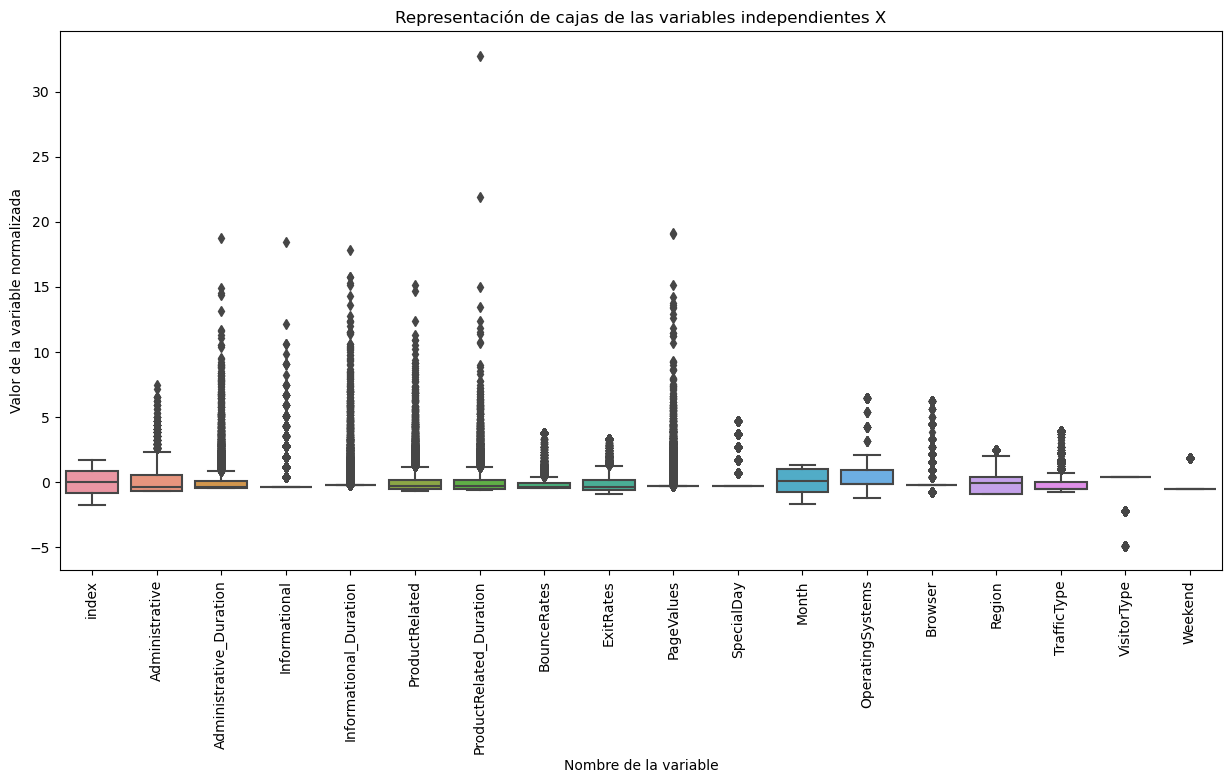

In [29]:
# Graficamos

plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_normalizado)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

De la figura observamos la cantidad de outliers que presenta cada variable del dataframe.

* Entre la segunda y novena columna se muestran las variables con mayor número de outliers del dataframe.
* La columna Browser y SpecialDay también presentan un gran número de outliers.

Dependiendo de la correlación existente entre las variables X con la variable Y podría ser conveniente tratar los outliers o incluso eliminar alguna variable.

## Histogramas

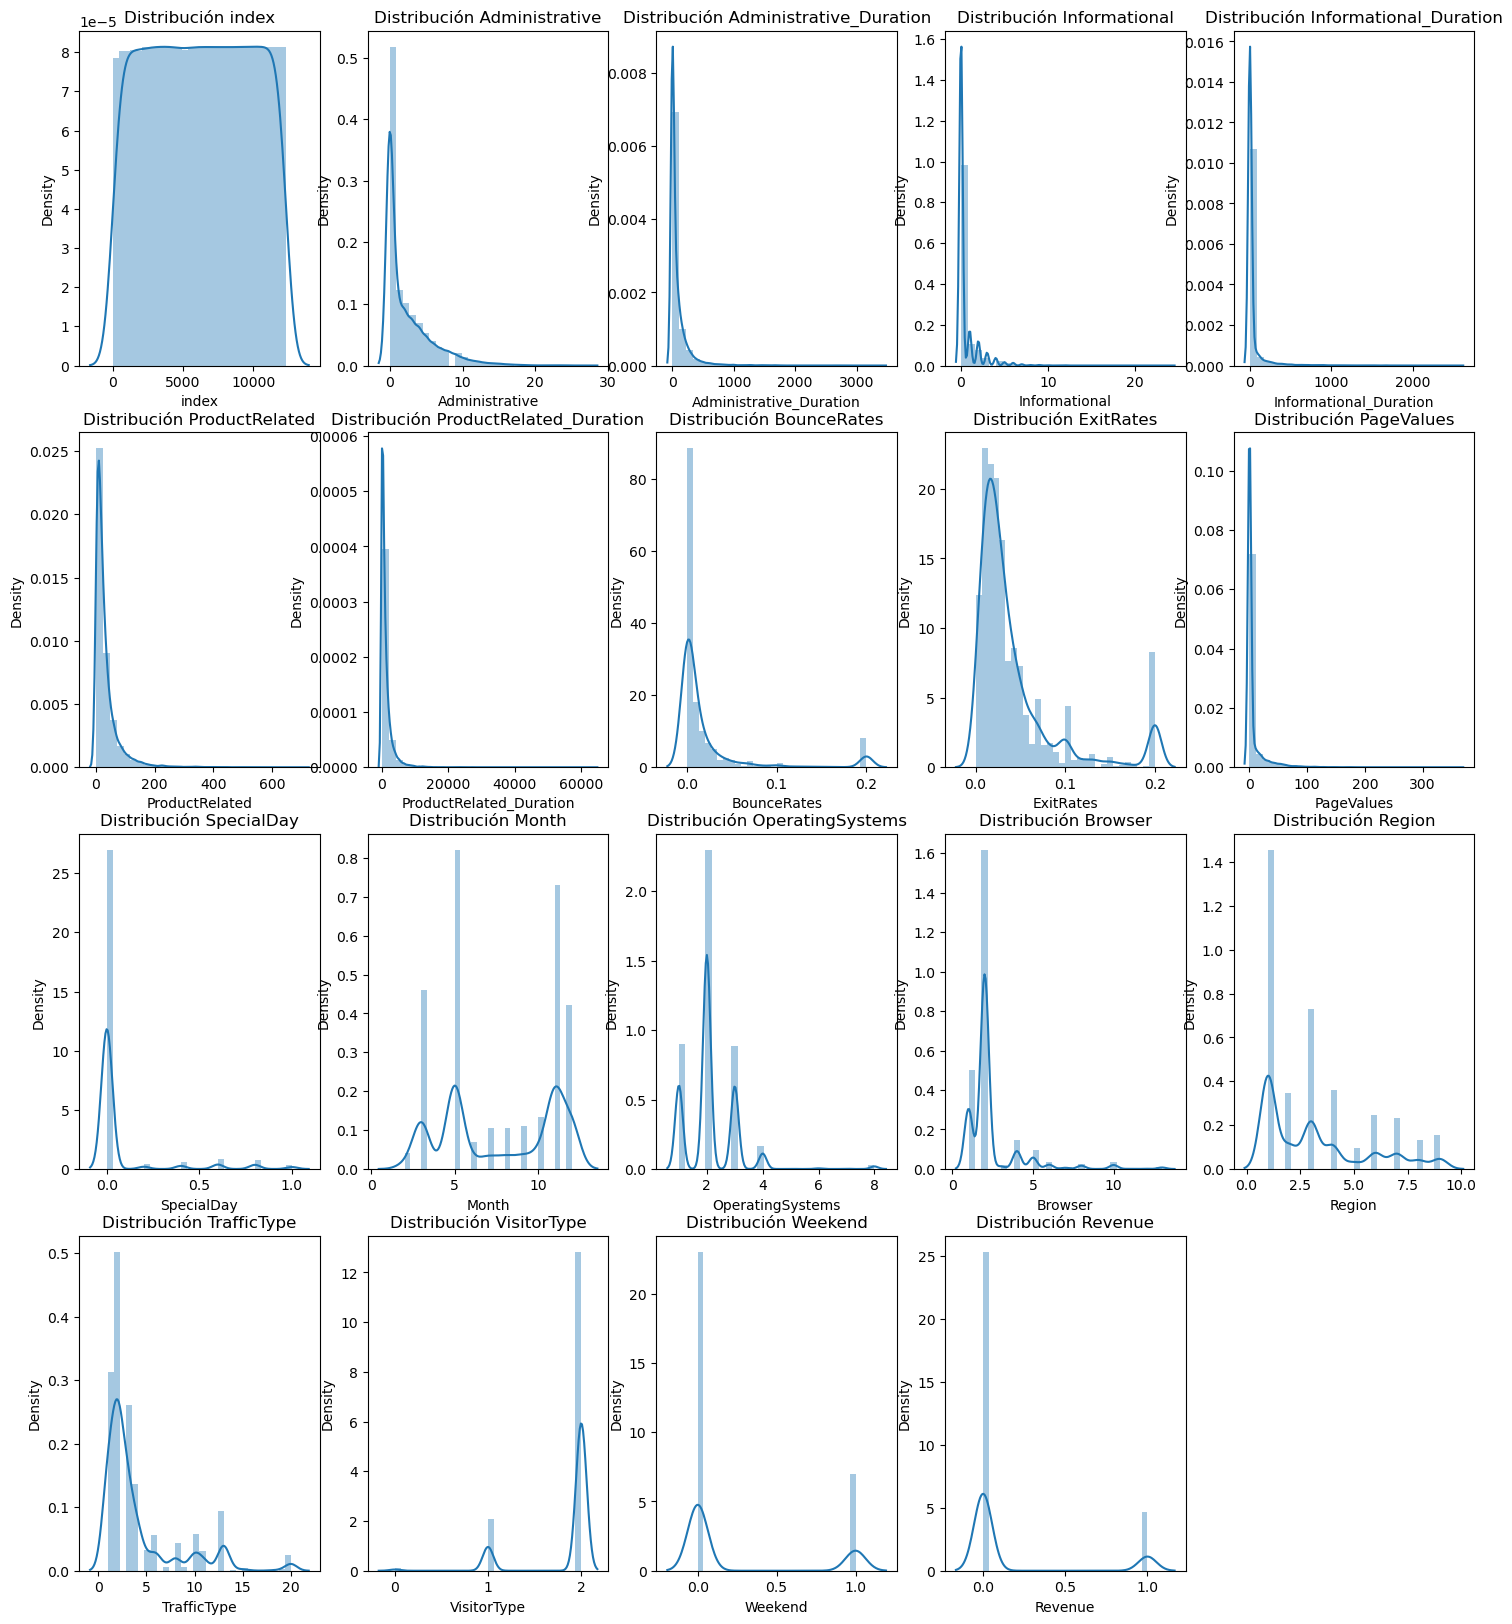

In [30]:
plt.figure(figsize=(18,20))
n = 0
for i, column in enumerate(XY.columns):
    n+=1
    plt.subplot(4, 5, n)
    sns.distplot(XY[column], bins=30)
    plt.title('Distribución {}'.format(column))
plt.show()
                

Tras analizar la distribución de las variables es mucho más sencillo tomar decisiones en cuanto al tratamiento de outlier.

No se observa ninguna tendencia anómala en los datos.

## Relación variable vs target

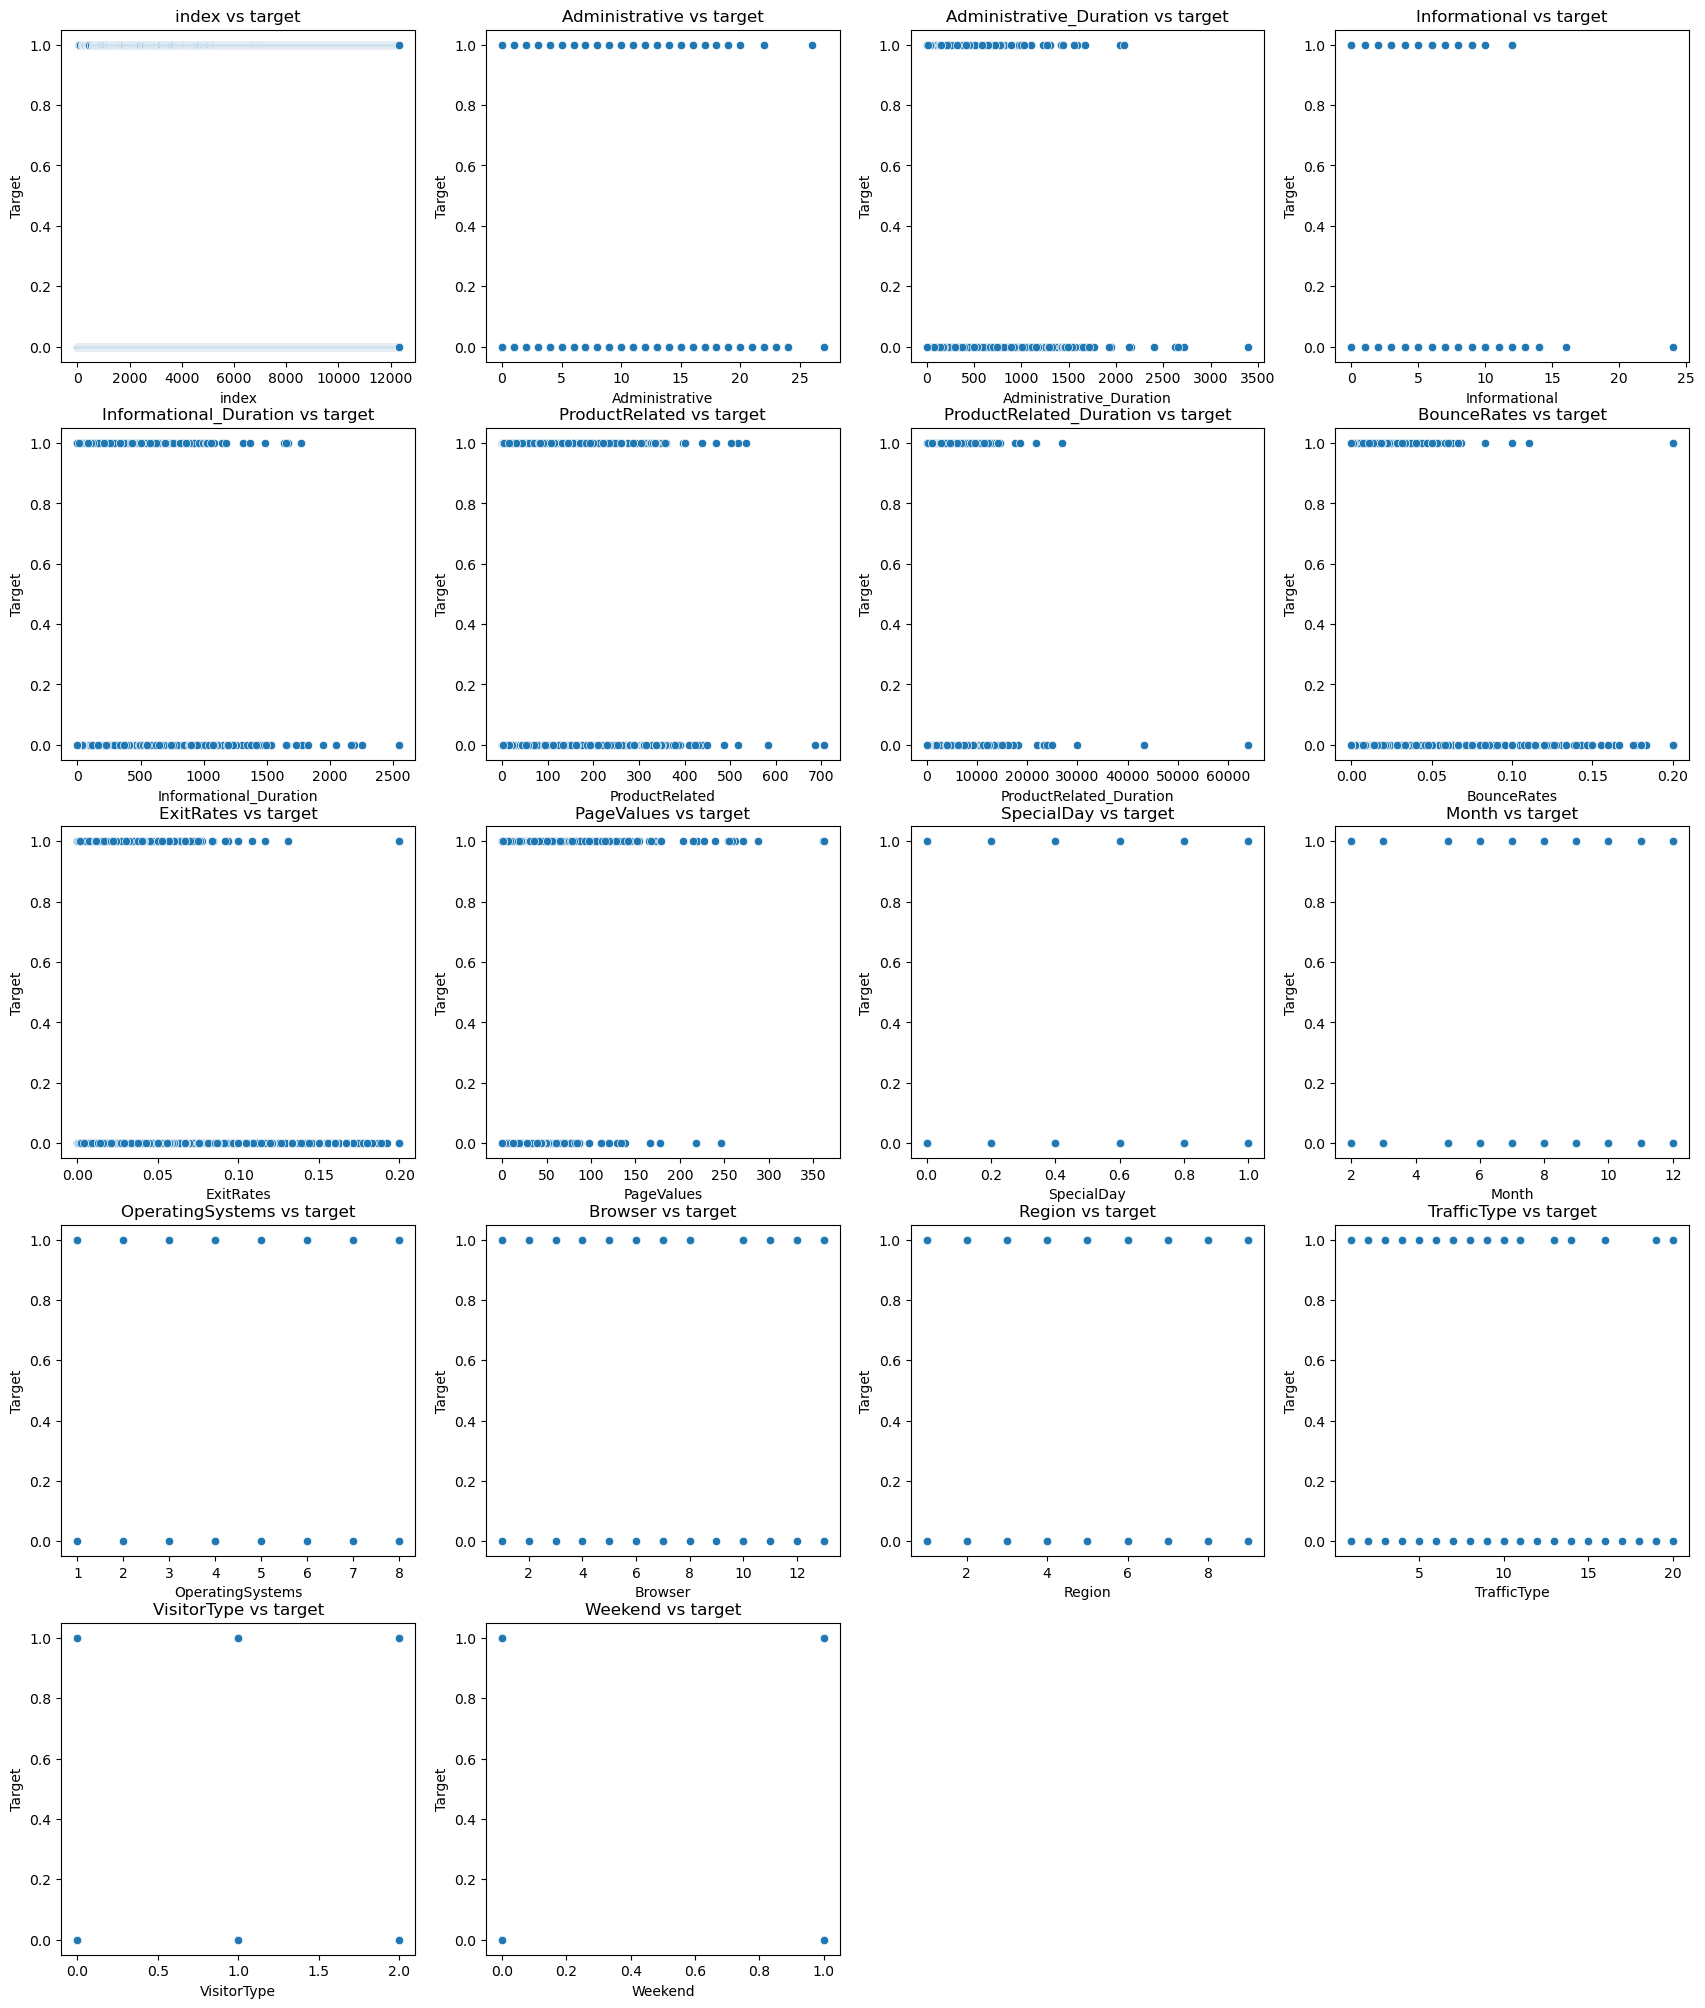

In [31]:
relaciones_vs_target(X, Y)

Conclusiones:
* A partir de cierta duración en una página web, deja de ser probable la compra de algún artículo:
    * Para tiempos mayores a 2500 de la variable Adminstrative_Duration, no es probable tener ingresos.
    * Para tiempos mayores a 2000 de la variable Informational_Duration, no es probable tener ingresos.
    * Para tiempos mayores a 30000 de la variable ProductRelated_Duration, no es probable tener ingresos.
* La mayoría de los usuarios que compran salen de desencadenando otra tarea adicional (BounceRates < 0.1 y ExitRates < 0.15).


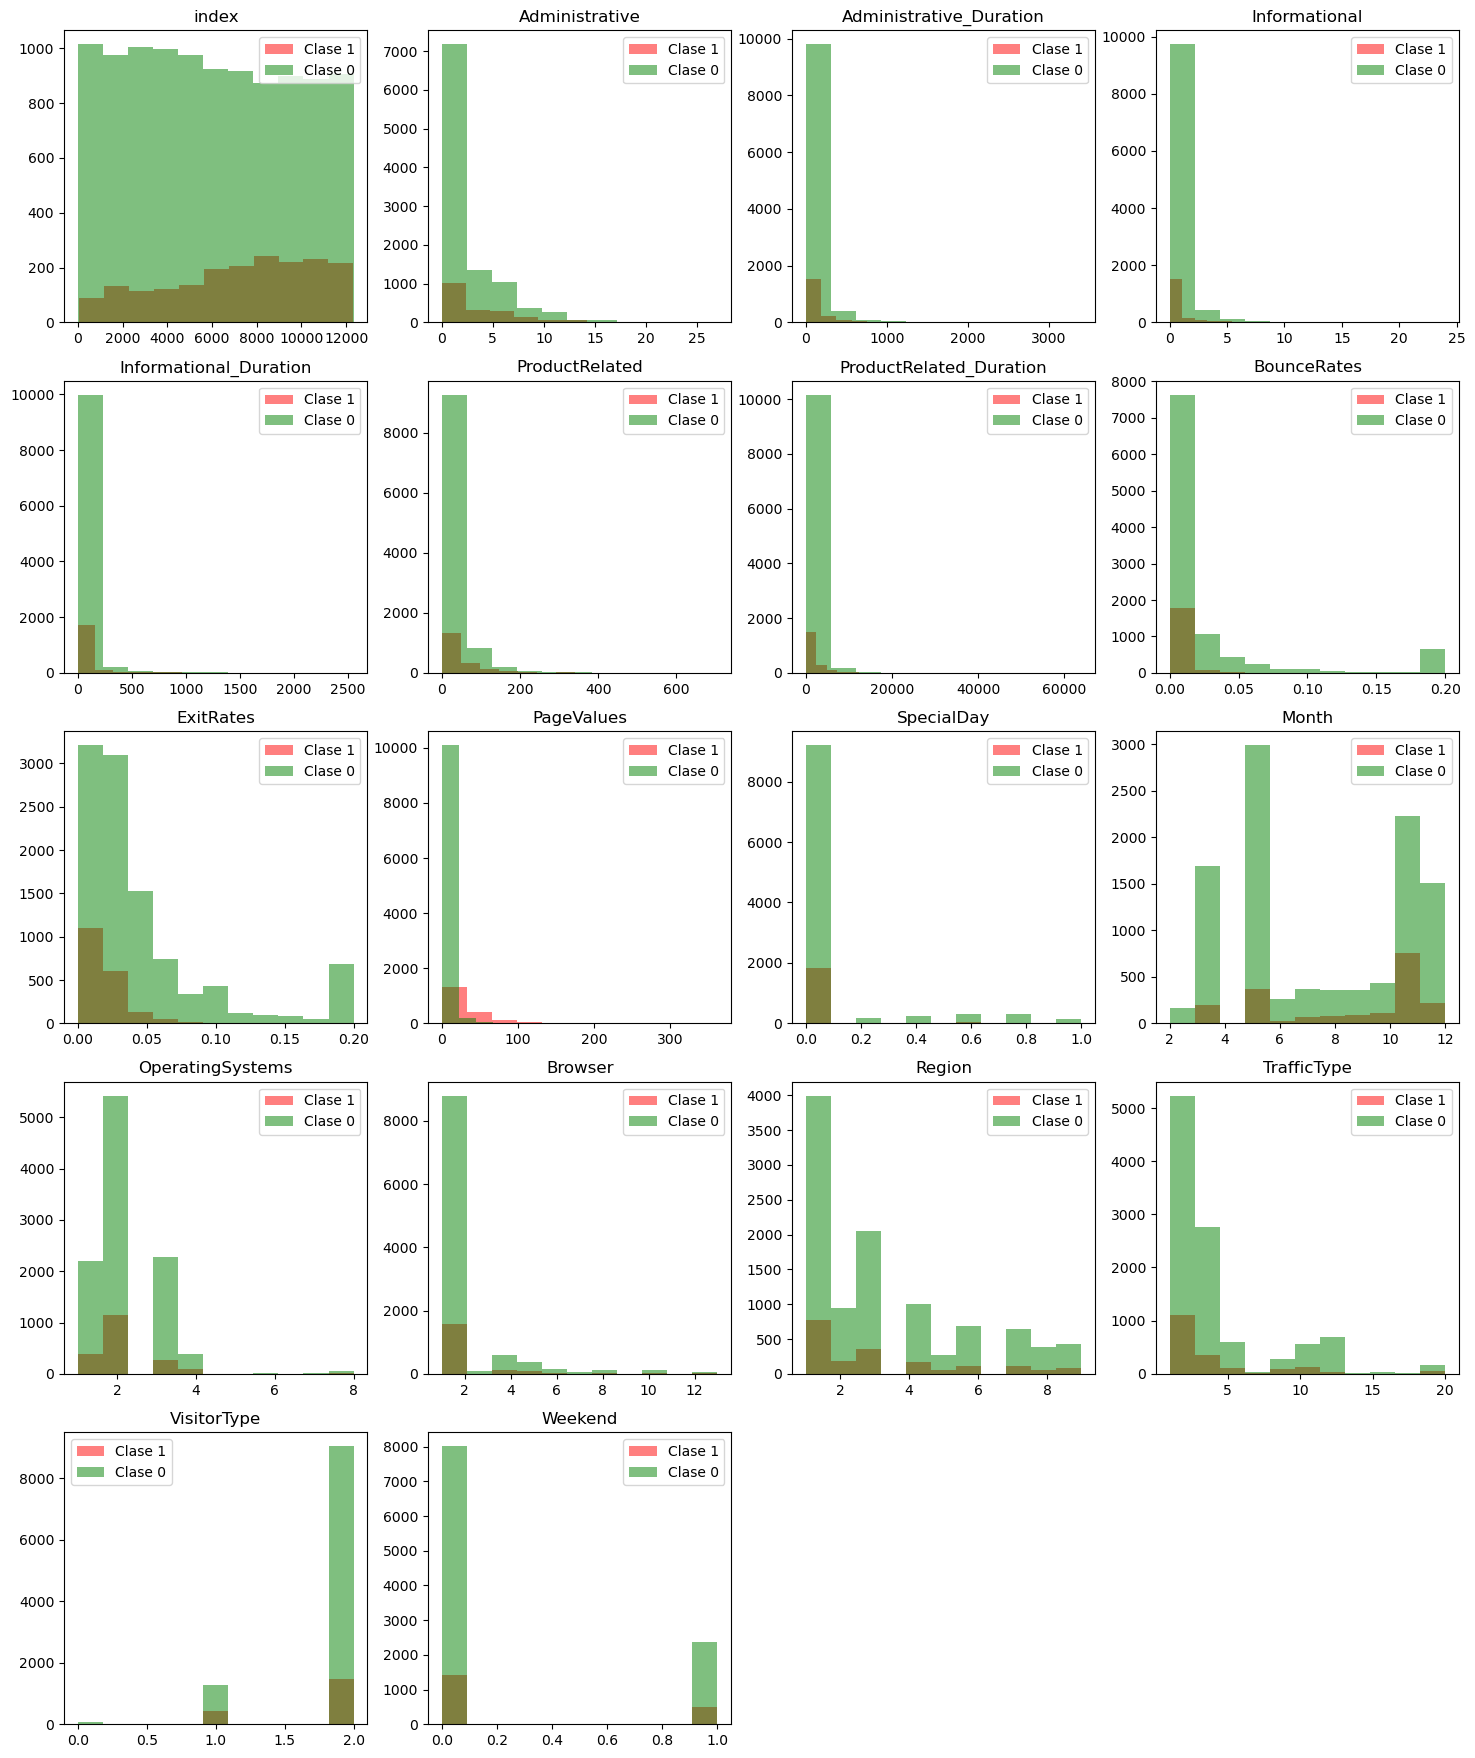

In [32]:
hist_pos_neg_feat(X,Y)

Conclusiones:
* Cuantas más páginas web, de un tipo, un usuario visita, menos probabilidad hay de tener ingresos.
* Existe un mayor número de ingresos para las visitas de las páginas web Informational y ProductRelated.
* Noviembre es el mes con mayor número de ingresos, seguido de Mayo.
* Duraciones de tiempo en paginas web > 200 el número de ingresos es muy bajo.
* El número de ingresos es mayor en los días de diario y en días lejanos a fechas especiales.

## Matriz de correlaciones 

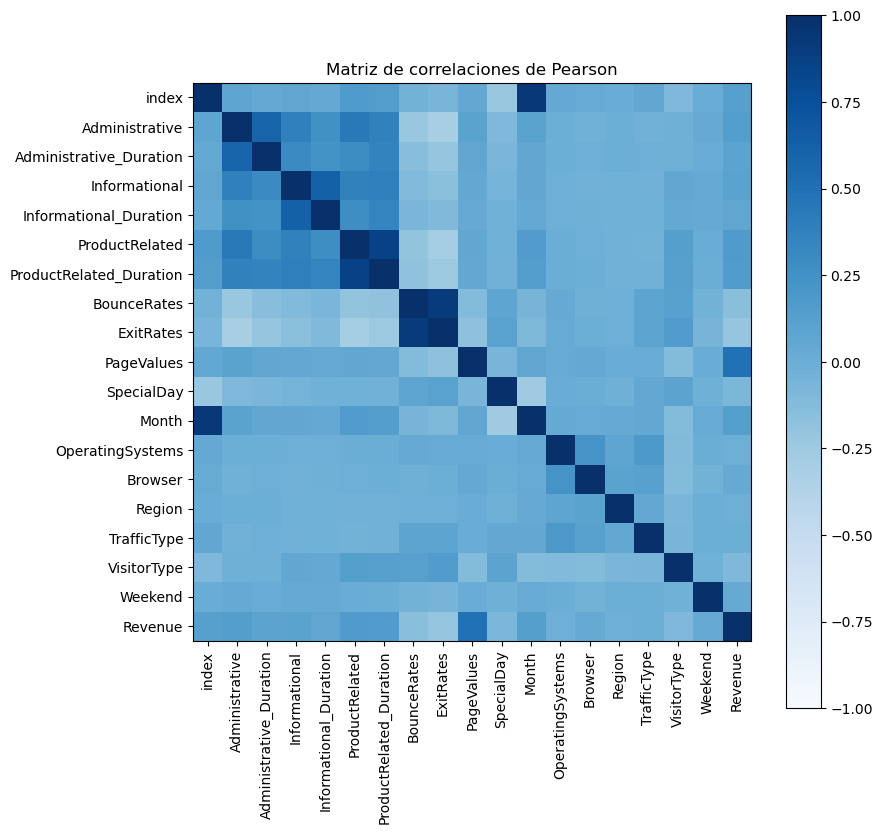

In [33]:
# Representa la matriz de correlaciones
matriz_correlaciones = XY.corr(method='pearson')
n_ticks = len(XY.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), XY.columns, rotation='vertical')
plt.yticks(range(n_ticks), XY.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap=plt.get_cmap('Blues')))
_ = plt.title('Matriz de correlaciones de Pearson')

Conclusiones:
* Variables independientes correlacionadas entre si:
    * Las variables de cada tipo de web y su tiempo de duración está altamente relacionadas entre si.
    * Las variables BounceRates y ExitRates están muy correlacionadas.
    * Las variables SpecialDay y Month también lo están.
    * Las variables OperatingSystems y Browser, tambien lo están.
    
* Variables independientes con mayor correación con la target:
    * PageValues
    * ProductRelated
    
Para evitar la correlación entre las variables independientes, se eliminan las variables de tiempo de duración, ExitRates, SpecialDay y OperatingSystems.
También se elimina la variable index, ya que no tiene valor alguno para la target.

In [34]:
XY = XY.drop(['index','Administrative_Duration', 'Informational_Duration','ProductRelated_Duration','ExitRates', 'SpecialDay', 'OperatingSystems'], axis = 1)

X = XY.drop('Revenue', axis = 1)
XY[:2]

,Administrative,Informational,ProductRelated,BounceRates,PageValues,Month,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,1.0,0.2,0.0,2,1,1,1,2,0,0
1,0.0,0.0,2.0,0.0,0.0,2,2,1,2,2,0,0


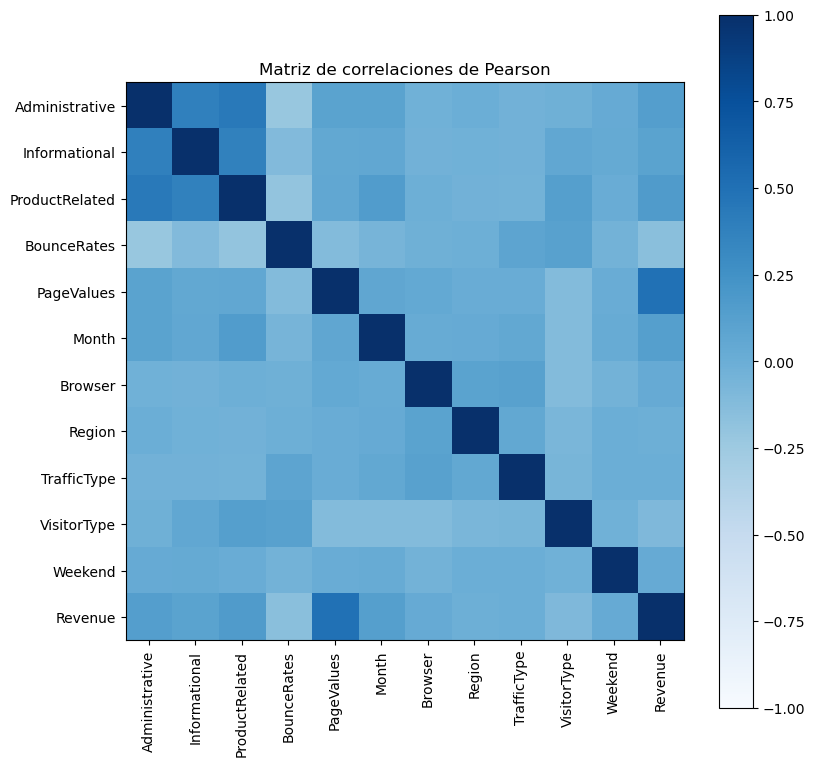

In [35]:
# Representa la matriz de correlaciones
matriz_correlaciones = XY.corr(method='pearson')
n_ticks = len(XY.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), XY.columns, rotation='vertical')
plt.yticks(range(n_ticks), XY.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap=plt.get_cmap('Blues')))
_ = plt.title('Matriz de correlaciones de Pearson')

In [36]:
# Variables más y menos correlacionadas con la target
correlaciones_target = matriz_correlaciones.values[ -1, : -1]
indices_inversos =  abs(correlaciones_target[ : ]).argsort()[ : : -1]
diccionario = {}
for nombre, correlacion in zip( X.columns[indices_inversos], list(correlaciones_target[indices_inversos] ) ):
    diccionario[nombre] = correlacion
pd.DataFrame.from_dict(diccionario, orient='index', columns=['Correlación con la target'])

,Correlación con la target
PageValues,0.492317
ProductRelated,0.157624
BounceRates,-0.149348
Administrative,0.137970
Month,0.125913
VisitorType,-0.097893
Informational,0.094672
Weekend,0.028937
Browser,0.024063
Region,-0.011575


En el orden mostrado se encuentran las variables más predictoras. Las dos primeras ya las habíamos mencionado anteriormente.

# 9. Modelado

## Estandarización de los datos

Hay modelos que parten de la base de que los datos son centrados y, por tanto, se necesita estandaizar. Esta práctica no suele perjudicar a los datos, por ello indifenetemente del modelo, se estandariza la variable X.

Los modelos basados en árboles son uno de los ejemplos en los que la estandarización es necesaria.

In [37]:
obj_escalar = StandardScaler()
X_estandarizado = obj_escalar.fit_transform(X)

## División en train y test

In [38]:
# Divide los datos en train y test, con un 20 % de tamaño de test
X_train, X_test, Y_train, Y_test = train_test_split(X_estandarizado, Y, test_size=0.2, random_state=0)

print ('Train set:', X_train.shape,  Y_train.shape)
print ('Test set:', X_test.shape,  Y_test.shape)

Train set: (9826, 11) (9826,)
Test set: (2457, 11) (2457,)


## a) Modelo de clasificación (Regresión logística)

In [39]:
# Ajusta el modelo por defecto a los datos de entrenamiento y predice test

modelo = LogisticRegression()
modelo.fit(X_train, Y_train)

LogisticRegression()

In [40]:
# Optimizamos los parámetros C y class_weight mediante el método de CrossValidation (cv). La métrica a optimizar queremos que sea la roc_auc.
modelo = LogisticRegression()
parametros = {"C": [0., 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.95], 
              "class_weight":['balanced', None]}
modelo_gs = GridSearchCV(modelo, param_grid=parametros,
                         cv = 5, scoring='roc_auc')
modelo_gs.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
                               0.08, 0.09, 0.95],
                         'class_weight': ['balanced', None]},
             scoring='roc_auc')

In [41]:
print('Los valores más adecuados tras la optimización son: {}'.format(modelo_gs.best_params_))
print('La mejor ROC AUC: {}'.format(round(modelo_gs.best_score_,3)))

Los valores más adecuados tras la optimización son: {'C': 0.95, 'class_weight': 'balanced'}
La mejor ROC AUC: 0.897


## b) Modelo de clasificación (Árbol de decisión)

In [42]:
modelo = DecisionTreeRegressor()
modelo.fit(X_train, Y_train)

DecisionTreeRegressor()

In [43]:
parametros = {"max_depth": range(3,7), 
              "min_samples_leaf": range(1, 3)}
modelo_gs = GridSearchCV(modelo, param_grid=parametros,
                         cv = 5, scoring='roc_auc')
modelo_gs.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(3, 7),
                         'min_samples_leaf': range(1, 3)},
             scoring='roc_auc')

In [44]:
print('Los valores más adecuados tras la optimización son: {}'.format(modelo_gs.best_params_))
print('La mejor ROC AUC: {}'.format(round(modelo_gs.best_score_,3)))

Los valores más adecuados tras la optimización son: {'max_depth': 5, 'min_samples_leaf': 1}
La mejor ROC AUC: 0.918


## c) Modelo Redes Neuronales (NN - clasificación binaria)

Dado que la busqueda de hiperparámetros de un modelo de redes neuronales puede resultar poco práctica con GridSearch.  En su lugar, se emplea random grid search, que hace una búsqueda de combinaciones aleatorias.

Los parámetros que se optimizan son:
* Número de capas ocultas (numero de neuronas, capas).
* Parámetro alpha
* Tasa de aprendizaje


In [45]:
param_distributions = {
    'hidden_layer_sizes': [(10), (10, 10), (20, 20)],
    'alpha': np.logspace(-3, 3, 7),
    'learning_rate_init': [0.001, 0.01, 0.1],
    }

grid = RandomizedSearchCV(
        estimator  = MLPClassifier(solver = 'lbfgs', max_iter= 2000),
        param_distributions = param_distributions,
        n_iter     = 50, # Número máximo de combinaciones probadas
        scoring    = 'roc_auc',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 3, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )


_ = grid.fit(X_train, Y_train)

In [46]:
print('Los valores más adecuados tras la optimización son: {}'.format(grid.best_params_))
print('La mejor ROC AUC: {}'.format(round(grid.best_score_,3)))

Los valores más adecuados tras la optimización son: {'learning_rate_init': 0.001, 'hidden_layer_sizes': 10, 'alpha': 1.0}
La mejor ROC AUC: 0.918


In [47]:
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(3)

,param_learning_rate_init,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
11,0.001,10,1.0,0.918050,0.002438,0.935083,0.003943
6,0.001,10,0.1,0.917617,0.002818,0.937392,0.000882
25,0.01,10,0.001,0.917113,0.000674,0.937929,0.001574


# 10. Representación de las probabilidades

Entre los tres modelos propuestos, el caso b) es el modelo más adecuado debido a que tiene el mayor ROC (0.919). Por lo tanto, este es el modelo elegido para continuar con la métrica.

In [48]:
# Recordatorio modelo árbol de decisiones

print('Los valores más adecuados tras la optimización son: {}'.format(modelo_gs.best_params_))
print('La mejor ROC AUC: {}'.format(round(modelo_gs.best_score_,3)))

Los valores más adecuados tras la optimización son: {'max_depth': 5, 'min_samples_leaf': 1}
La mejor ROC AUC: 0.918


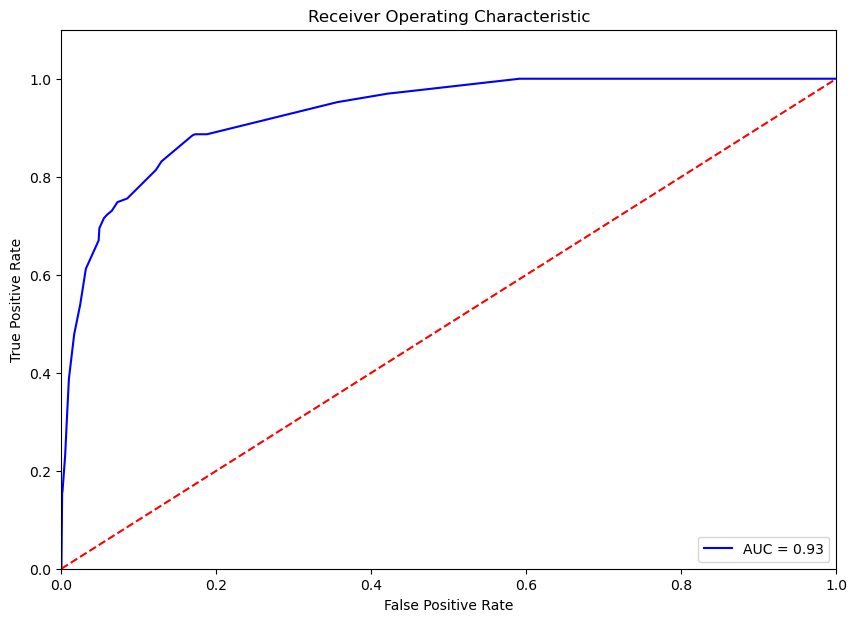

In [49]:
# Representa la curva ROC de las predicciones en Test
y_test_pred_prob = modelo_gs.predict(X_test)
preds = y_test_pred_prob
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

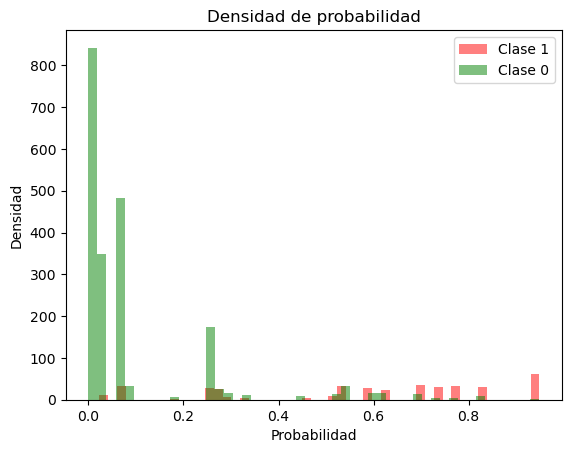

In [50]:
# Representa los histogramas de probabilidad de las predicciones en Test
y_test_pred_prob = modelo_gs.predict(X_test)
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]

represento_doble_hist(y_test_pred_prob_pos, y_test_pred_prob_neg, n_bins=50, normed=0)
plt.title('Densidad de probabilidad')
plt.ylabel('Densidad')
plt.xlabel('Probabilidad')
plt.show()

De la gráfica ROC observamos que:

* El modelo a partir de una tasa de falsos positivos inferior a 0.6 se alcanza una tasa de verdaderos positivos cercana a la unidad.

De la figura 'Densidad de probabilidad' observamos:

* El modelo es adecuado, ya que para las mayores probabilidades se encuantran las mayores tasas de acierto.
* La densidad de la clase 1 es inferior a la clase 0 debido al número tan elevado de de valores 0 en los datos originales.
* A partir de un 60% de probabilidad la desidad de aciertos crece. Luego, posiblemente establecer un umbral alrededor de este valor permitirá obtener un valor de exactitud elevado.


# 11. Umbralización

In [51]:
precisiones = {} 
for umbral in [0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_umbralizadas = 1*(y_test_pred_prob > umbral)
    precisiones[umbral] = metrics.precision_score(Y_test, y_umbralizadas)
precisiones

{0.1: 0.49787835926449786,
 0.2: 0.5021459227467812,
 0.3: 0.6839622641509434,
 0.5: 0.7153652392947103,
 0.6: 0.8106060606060606,
 0.7: 0.8850574712643678,
 0.8: 0.9019607843137255,
 0.9: 0.9682539682539683}

In [52]:
# Calcula las métricas accuracy, sensitividad, predición y la matriz de confusión con el umbral 
# por defecto 0.5
y_umbralizadas = 1*(y_test_pred_prob > 0.6)
print(u"Matriz de confusión\n", metrics.confusion_matrix(Y_test, y_umbralizadas))
print("\nExactitud\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))  

Matriz de confusión
 [[2010   50]
 [ 183  214]]

Exactitud	0.91
Sensitividad	0.54
Precisión	0.81


Conclusiones:

* Se define un umbral de > 0.6
* Se obtienen unos valores de exactitud muy elevados 91%
* Se obtiene una precisión del 81%
* A cambio de los valores definidos se obtine una sensibilidad aceptable del 54% dado el objetivo del modelo.

